### Import necessary packages

In [71]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import geojson
import pandas as pd
from shapely.geometry import shape
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### Import study area boundary file

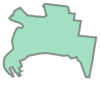

In [72]:
with open('CityOfMelbourne_municipal-boundary.geojson') as f:
    gj = geojson.load(f)
polygon = shape(gj['features'][0]['geometry'])
polygon

### Download OSM data using OSMnx and construct a graph

In [73]:
bike_filter_1 = '[~"highway"~"cycleway|trunk|primary|secondary|tertiary|unclassified|residential|primary_link|secondary_link|tertiary_link|living_street|trailhead|service"]["access"!~"no|private"]["bicycle"!~"no"]["area"!~"yes"]'
G1 = ox.graph.graph_from_polygon(polygon, custom_filter = bike_filter_1, simplify = False, retain_all=True)

bike_filter_2 = '[~"highway"~"footway|pedestrian|path"]["bicycle"~"yes|designated|dismount"]["area"!~"yes"]'
G2 = ox.graph.graph_from_polygon(polygon, custom_filter = bike_filter_2, simplify = False, retain_all=True)

G = nx.compose(G1, G2)
G_nodes, G_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### You can also use the *graph_from_place* function if you do not have a boundary file

In [74]:
bike_filter_1 = '[~"highway"~"cycleway|trunk|primary|secondary|tertiary|unclassified|residential|primary_link|secondary_link|tertiary_link|living_street|trailhead|service"]["access"!~"no|private"]["bicycle"!~"no"]["area"!~"yes"]'
G1 = ox.graph.graph_from_place('City of Melbourne', custom_filter = bike_filter_1, simplify = False, retain_all=True)

bike_filter_2 = '[~"highway"~"footway|pedestrian|path"]["bicycle"~"yes|designated|dismount"]["area"!~"yes"]'
G2 = ox.graph.graph_from_place('City of Melbourne', custom_filter = bike_filter_2, simplify = False, retain_all=True)

G = nx.compose(G1, G2)
G_nodes, G_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### Plot the graph

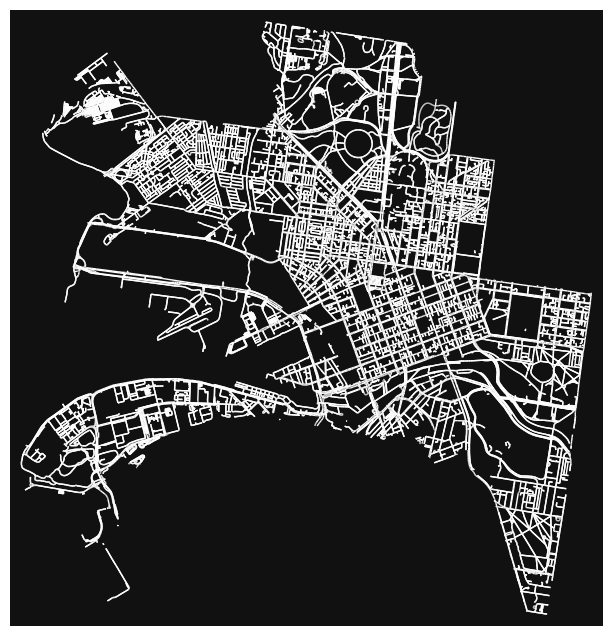

In [75]:
fig, ax = ox.plot_graph(G, node_size=0, edge_color='#FFFFFF', show=True)

### Examine highway tag distribution

<Axes: xlabel='highway'>

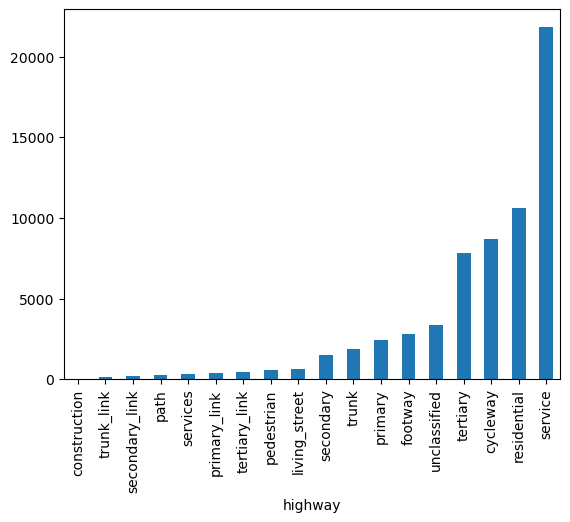

In [76]:
G_edges['highway'].value_counts(dropna=False)
G_edges['highway'].value_counts().sort_values().plot(kind = 'bar')

### Create new highway/road classification and examine

In [77]:
G_edges['hway_cls'] = ''

G_edges.loc[G_edges['highway'].isin(['motorway_link','motorway']), 'hway_cls'] = 'motorway'
G_edges.loc[G_edges['highway'].isin(['secondary','primary','trunk','secondary_link','primary_link','trunk_link']), 'hway_cls'] = 'arterial'
G_edges.loc[G_edges['highway'].isin(['tertiary','tertiary_link']), 'hway_cls'] = 'collector'
G_edges.loc[G_edges['highway'].isin(['residential','service','services','unclassified','living_street']), 'hway_cls'] = 'local'
G_edges.loc[G_edges['highway'].isin(['cycleway','footway','pedestrian','path']), 'hway_cls'] = 'paths and crossings'
G_edges.loc[G_edges['highway'].isin(['construction','proposed','disused']), 'hway_cls'] = 'other'
G_edges.loc[G_edges['highway'].isna(), 'hway_cls'] = 'other'

G_edges['hway_cls'].value_counts()

hway_cls
local                  36757
paths and crossings    12332
collector               8270
arterial                6486
other                    196
Name: count, dtype: int64

#### Plot by sum of total road count of each highway class

<Axes: xlabel='hway_cls'>

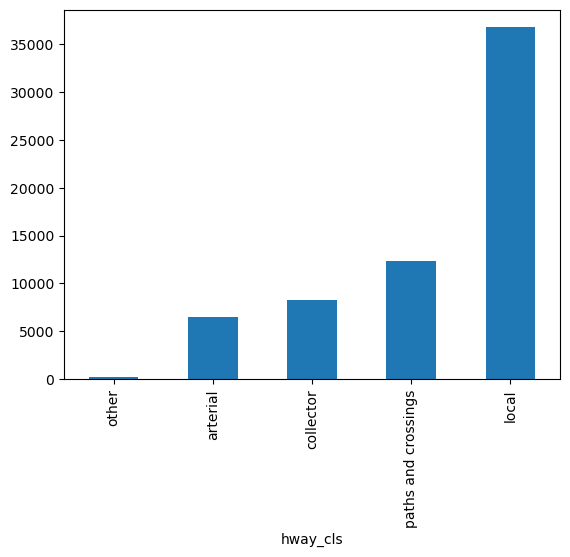

In [78]:
G_edges['hway_cls'].value_counts().sort_values().plot(kind = 'bar')

#### Plot by sum of total road length (in metres) of each highway class

<Axes: xlabel='hway_cls'>

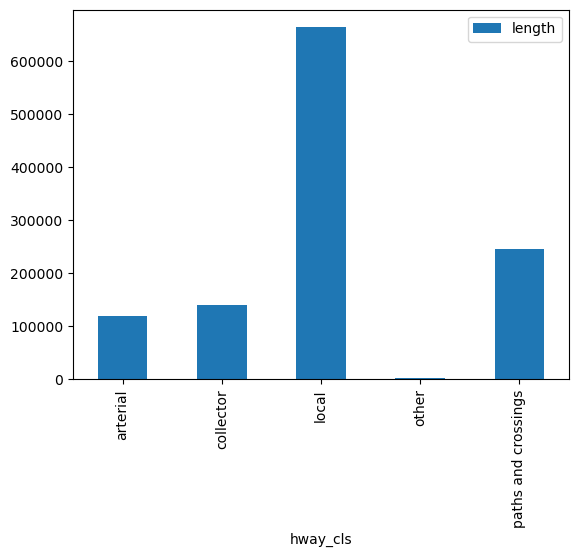

In [79]:
G_edges[['hway_cls','length']].groupby('hway_cls').sum().plot(kind = 'bar')

### Recreate graph using modified edges geodataframe

In [80]:
G = ox.utils_graph.graph_from_gdfs(G_nodes, G_edges)

att_list = ['geometry']
for n1, n2, d in G.edges(data=True):
    for att in att_list:
        d.pop(att, None)

### Plot new graph with highway classes colour-coded

In [81]:
edge_types = G_edges['hway_cls'].value_counts()
color_list = ox.plot.get_colors(n=len(edge_types), cmap='plasma_r')
color_mapper = pd.Series(color_list, index=edge_types.index).to_dict()
color_mapper

{'local': (0.940015, 0.975158, 0.131326, 1.0),
 'paths and crossings': (0.971835, 0.580382, 0.254931, 1.0),
 'collector': (0.794549, 0.27577, 0.473117, 1.0),
 'arterial': (0.489055, 0.010127, 0.658534, 1.0),
 'other': (0.050383, 0.029803, 0.527975, 1.0)}

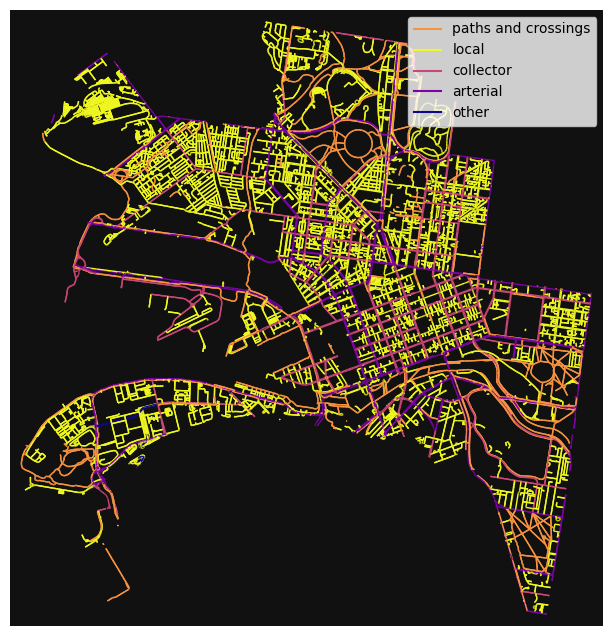

In [82]:
# get the color for each edge based on its highway type
ec = [color_mapper[d['hway_cls']] for u, v, k, d in G.edges(keys=True, data=True)]
handles = [Line2D([], [], color=color, label=label)
           for color, label in zip([color_mapper['paths and crossings'], 
                                    color_mapper['local'], 
                                    color_mapper['collector'],
                                   color_mapper['arterial'],
                                   color_mapper['other']], 
                                   ["paths and crossings",
                                    "local", 
                                    "collector",
                                    "arterial",
                                    "other"])]
fig, ax = ox.plot_graph(G, edge_color=ec, node_size=0, show=False)
ax.legend(handles=handles)
plt.show()